## Import Neccesary Modules.

In [2]:
import tensorflow as tf
tf.__version__
import pandas as pd
print(pd.__version__)
import os
import numpy as np
import cv2
print(cv2.__version__)

2.1.4
4.9.0


In [3]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [4]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

In [5]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [6]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [7]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [8]:
input_shape = (512, 512, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 512, 512, 64)         0         ['batch_normalization[0][0

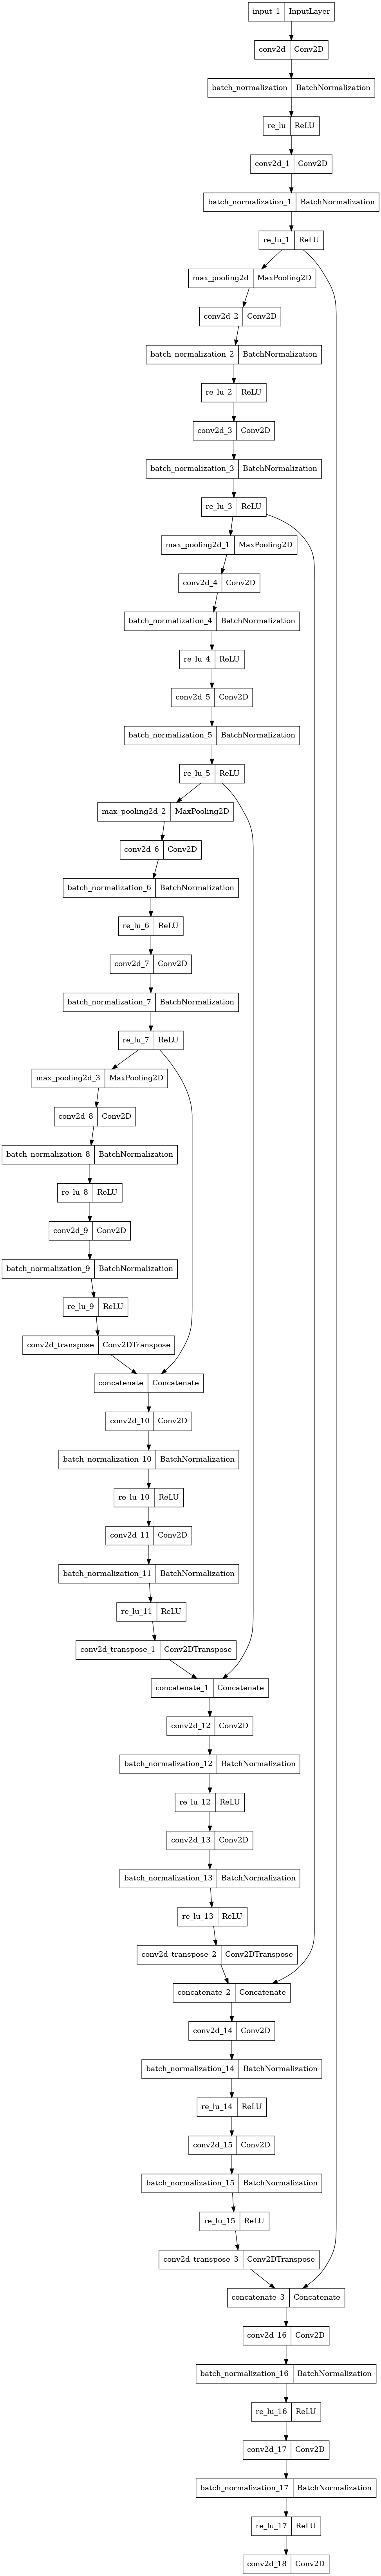

In [9]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

#### To run the above code simply follow the following instructions you need to install `PyDot` and `GraphViz`

`sudo apt install graphviz`

= `pip install pydot`; conda version doesn't work



### Define the input image and target mask parameters

In [10]:
import os

dirnum = 1 # Which dataset to be processed you can mention here
#parent_main_dir = f"/kaggle/input/cropped-dataset-final/27808_1_{dirnum}_cropped/27808_1_{dirnum}_cropped" ## If running on Kaggle
parent_main_dir  = f"datasets/cropped-dataset-final/27808_1_{dirnum}_cropped/27808_1_{dirnum}_cropped"

input_dir = os.path.join(parent_main_dir,"images" )
target_dir = os.path.join(parent_main_dir, "masks")
target_size = img_size = (512, 512)



### Convert the input folder images from uint16 into np.float32 and resize into target size

In [10]:
'''import os
import cv2
import numpy as np

target_size = (512, 512)  # replace with your target size

# Get list of all files in input directory
files = os.listdir(input_dir)

for file in files:
    # Construct full file path
    file_path = os.path.join(input_dir, file)
    
    # Read image
    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    
 
        
    # Resize
    img = cv2.resize(img, target_size)
        
    # Save image, replacing original
    cv2.imwrite(file_path, img)'''

### Resize the target masks into target size


In [11]:

'''import os
import cv2
import numpy as np

target_size = (512, 512)  # replace with your target size

# Get list of all files in input directory
files = os.listdir(target_dir)

for file in files:
    # Construct full file path
    file_path = os.path.join(target_dir, file)
    
    # Read image
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize
    img = cv2.resize(img, target_size)
    
    # Save image, replacing original
    cv2.imwrite(file_path, img)'''


#### Define function to normalize image as well as convert from uint16 to np.float32 and reshape the image size to (512, 512)

In [11]:
import numpy as np

def normimg(img):
    """
    Converts a uint16 image to a normalized float image.

    Args:
    image: A numpy array representing the uint16 image.

    Returns:
    A numpy array representing the normalized float image.
    """

    # Check if the input is a uint16 image
    #if not image.dtype == np.uint16:
    #    raise ValueError("Input image must be of type uint16.")

    # Normalize the image to the range [0, 1]
    img = np.float32(cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_LINEAR))
    
    img =  (img - np.min(img))/(np.max(img) - np.min(img))
    
    return img

### Define batch size and the num_classes = 1


In [12]:
num_classes = 1
batch_size = 8

### Dataloader and count the number of input and target files

In [13]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".tiff")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".tiff") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 631
datasets/cropped-dataset-final/27808_1_1_cropped/27808_1_1_cropped/images/Img000000_cropped.tiff | datasets/cropped-dataset-final/27808_1_1_cropped/27808_1_1_cropped/masks/00000_mask.tiff
datasets/cropped-dataset-final/27808_1_1_cropped/27808_1_1_cropped/images/Img000001_cropped.tiff | datasets/cropped-dataset-final/27808_1_1_cropped/27808_1_1_cropped/masks/00001_mask.tiff
datasets/cropped-dataset-final/27808_1_1_cropped/27808_1_1_cropped/images/Img000002_cropped.tiff | datasets/cropped-dataset-final/27808_1_1_cropped/27808_1_1_cropped/masks/00002_mask.tiff
datasets/cropped-dataset-final/27808_1_1_cropped/27808_1_1_cropped/images/Img000003_cropped.tiff | datasets/cropped-dataset-final/27808_1_1_cropped/27808_1_1_cropped/masks/00003_mask.tiff
datasets/cropped-dataset-final/27808_1_1_cropped/27808_1_1_cropped/images/Img000004_cropped.tiff | datasets/cropped-dataset-final/27808_1_1_cropped/27808_1_1_cropped/masks/00004_mask.tiff
datasets/cropped-dataset-final/27808_

#### Display a random image

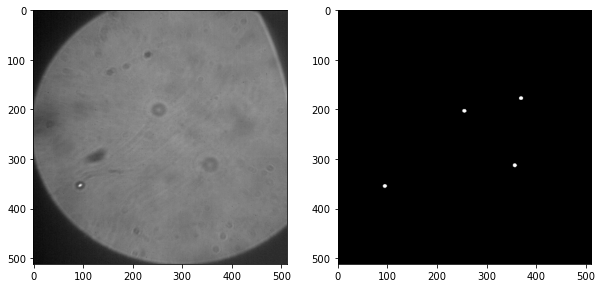

In [14]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

#Store a random number
rnd_index = np.random.randint(len(input_img_paths))
# Display input image 
fig, ax = plt.subplots(1, 2, figsize=[10, 10])
#img_load = load_img(input_img_paths[rnd_index])
ax[0].imshow(normimg((plt.imread(input_img_paths[rnd_index]))), cmap='gray')
ax[1].imshow(normimg((plt.imread(target_img_paths[rnd_index]))), cmap='gray')

plt.show()

In [15]:
np.unique(plt.imread(input_img_paths[rnd_index]))

array([    0,    16,   272,   432,   688,   848,  1008,  1152,  1296,
        1376,  1520,  1600,  1664,  1744,  1888,  1968,  2048,  2112,
        2176,  2240,  2320,  2384,  2448,  2512,  2592,  2656,  2720,
        2784,  2864,  2928,  2992,  3056,  3136,  3200,  3264,  3328,
        3376,  3440,  3504,  3568,  3632,  3696,  3760,  3824,  3888,
        3952,  4016,  4080,  4144,  4192,  4256,  4320,  4368,  4432,
        4496,  4544,  4608,  4672,  4720,  4784,  4848,  4912,  4960,
        5024,  5088,  5136,  5184,  5248,  5296,  5360,  5408,  5472,
        5520,  5584,  5632,  5696,  5744,  5808,  5856,  5904,  5968,
        6016,  6064,  6128,  6176,  6224,  6288,  6336,  6384,  6432,
        6496,  6592,  6640,  6704,  6752,  6800,  6848,  6896,  6960,
        7008,  7056,  7152,  7200,  7248,  7296,  7360,  7408,  7456,
        7552,  7600,  7648,  7696,  7744,  7840,  7888,  7936,  7984,
        8080,  8128,  8176,  8224,  8320,  8368,  8400,  8448,  8544,
        8592,  8640,

In [16]:
mask = normimg((plt.imread(target_img_paths[rnd_index])))

In [17]:
np.max(mask.ravel())

1.0

In [18]:
samp_img = plt.imread(input_img_paths[rnd_index])
samp_mask = plt.imread(target_img_paths[rnd_index])

In [19]:
samp_img.shape

(687, 623)

In [20]:
assert samp_img.shape == samp_mask.shape

In [21]:
img_size = (512,512)

In [22]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class TweezerSeg(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            #img = normimg(np.array(load_img(path, target_size=self.img_size))) # This is in general
            img = normimg(np.array(plt.imread(path)))
            #print(img.shape)
            
            
            x[j] = np.stack((img, img, img), axis = -1)
            #print(x[0].shape)
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            #img = cv2.resize(np.array(load_img(path, target_size=self.img_size, color_mode="grayscale")), dsize=(512, 512))
            imgmask = normimg(np.array(plt.imread(path)))
            y[j] = np.expand_dims(imgmask, -1)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        return x, y

In [23]:
import random
# Split our img paths into a training and a validation set
val_samples = 100
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = TweezerSeg(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = TweezerSeg(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## We will be saving the predicted masks as images.

- Read each image numpy array as Tensorflow Tensor Array. 
- Pass the image array through the model for prediction.

## Visualize using Train gen and Test Gen

In [24]:
import numpy
tempimg = train_gen.__getitem__(2)[1][0]

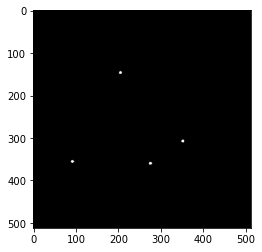

In [25]:
plt.imshow(tempimg, cmap = 'gray')

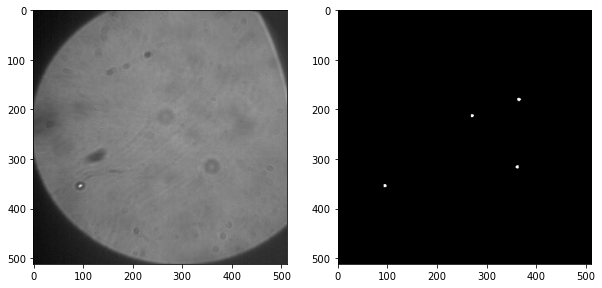

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = [10, 10])

for i in range(2):
    tempimg = train_gen.__getitem__(2)[i][3]
    ax[i].imshow(tempimg, cmap = 'gray')
    
plt.show()

# Model Training( Skip to `Pre-Trained Model predcition` for pre-trained weights)

In [27]:
model.compile(optimizer= tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam')
, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))

callbacks = [
    keras.callbacks.ModelCheckpoint("final_tweezer_new.tf", save_best_only=True, save_format="tf")
]

# Train the model, doing validation at the end of each epoch.
epochs = 20
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL ResourceExhaustedError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/framework/errors_impl.py(377): __init__
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/context.py(1457): call_function
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(196): __call__
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py(1349): _call_flat
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compiler.py(148): __call__
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(890): _call
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(825): __call__
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py(1742): fit
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py(65): error_handler
  <ipython-input-27-b1520c4f8744>(24): <module>
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3505): run_code
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3445): run_ast_nodes
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3266): run_cell_async
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3061): _run_cell
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3006): run_cell
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py(539): run_cell
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py(302): do_execute
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/gen.py(234): wrapper
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py(536): execute_request
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/gen.py(234): wrapper
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py(261): dispatch_shell
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/gen.py(234): wrapper
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py(358): process_one
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/gen.py(786): run
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/gen.py(825): inner
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/ioloop.py(738): _run_callback
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/ioloop.py(685): <lambda>
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/asyncio/events.py(80): _run
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py(1905): _run_once
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py(601): run_forever
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py(195): start
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py(619): start
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py(1075): launch_instance
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py(16): <module>
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/runpy.py(87): _run_code
  /home/vinayak-amd/anaconda3/envs/tf/lib/python3.9/runpy.py(197): _run_module_as_main


## Plot the test and the validation losses...



In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predict some model outputs...

In [50]:
# Display some model outputs
num_samples_to_display = 5  # You can change this number based on your preference
# Generate predictions on the validation set
val_predictions = model.predict(val_gen)

12/12 [==============================] - 8s 635ms/step


In [51]:
val_gen

In [52]:
list_of_inputs = [i for i in val_gen]

In [53]:
val_prediction = model.predict(list_of_inputs[0][0])

1/1 [==============================] - 0s 425ms/step


In [54]:
val_prediction.shape

(8, 512, 512, 1)

In [55]:
list_of_inputs[0][1][0].shape

(512, 512, 1)

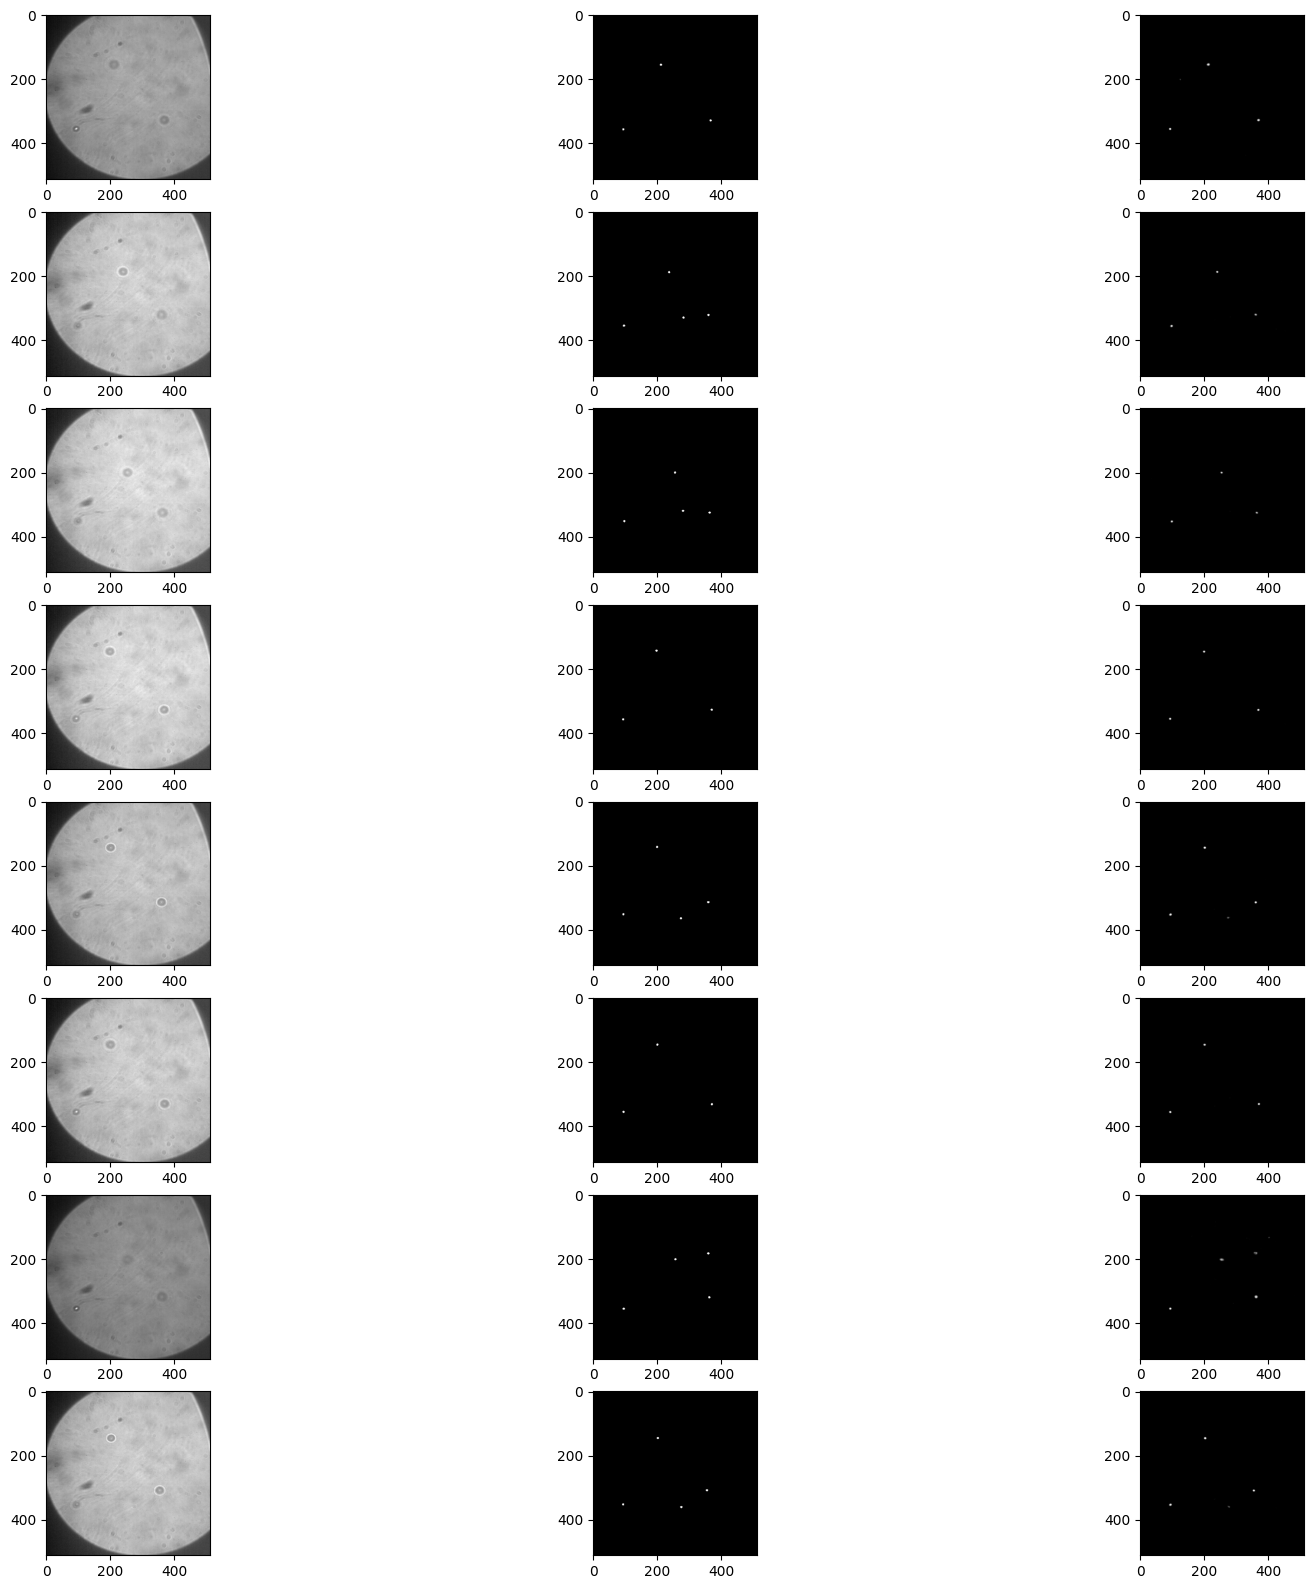

In [56]:
# Compare the Input ground truth and the model predictions
import matplotlib.pyplot as plt
import numpy as np  # Assuming you have some image data

# Generate some example image data (replace this with your actual image data)

fig, ax = plt.subplots(8, 3, figsize =(20, 20))

for i in range(8):
    for j in range(3):
        
        if j == 2:
            ax[i, j].imshow(val_prediction[i].squeeze(), cmap='gray')
        elif j==1:
            ax[i, j].imshow(list_of_inputs[0][1][i], cmap='gray')  # Use 'cmap' if your images are grayscale
        elif j==0:
            ax[i, j].imshow(list_of_inputs[0][0][i], cmap='gray')
            
            
plt.show()
im

In [57]:
list_of_inputs = list(val_gen)

# Pre-Trained model predicition

 Use pretrained saved model to process your already existing dataset i.e.the frame of the .cine files extisting the directory below.

- Sample Dataset directory - `/media/vinayak-amd/Backup/Home/KKS_Dataset`
- Sample Variable model path - `models/27808_1/variables/kaggle/working/final_tweezer_new.tf`

- We will save all the mask as tiffile
The current dataset directory upto two levels is as follows:





 ```Bash
 /media/vinayak-amd/Backup/Home/KKS_Dataset/27808_1_1
├── images_original
└── mask_predicted
```



#### Load the pre-trained model on local PC (trained on Kaggle)

In [27]:


model_path = "models/27808_1/variables/kaggle/working/final_tweezer_new.tf"
model = tf.keras.models.load_model(model_path)

#### Check for the GPU existence

In [30]:
## Verify if the GPU exists
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU in use")
else:
    print("GPU not in use")

GPU in use


#### Processing using pre-trained model



- Now use a existing folder to read all the tiff files and then pass it to the model for prediction.
- Save these masks after passing the images to the model and save the output masks in a seperate folder

- Cropping limits for the images in dirnum = 1 
    - (3, 689, 398, 1020)
    - (minX, maxX, minY, maxY) = (3, 689, 398, 1020)
- Cropping limits for the images in dirnum  = 2, 3, 
    - (392, 816, 277, 676)#
    - (minX, maxX, minY, maxY) = (392, 816, 277, 676)


- Processing Pipeline:

    - First crop. 
    - Then Resize.
    - Then pass through the pretrained model, to obtain segmentation masks
    - Binarize the segmentation masks, the bounding box label should display the contrast of the feature
    - Then using some algorithm track the particle.

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 512, 512, 64)         0         ['batch_normalization[0][0

## Save the masks to the desination directory

In [32]:
## First do some random tests on the model may  be uptil certain image...


import glob
from PIL import Image
import numpy as np
import os

# Define the source and the directory & the model path
parent_dir = '/media/vinayak-amd/Backup/Home/KKS_Dataset/27808_1_1'
src_dir = os.path.join(parent_dir, 'images_original')
dest_dir = os.path.join(parent_dir, 'mask_predicted')
model_path = model_path

# Check if the directory exist otherwise give assertion error
assert os.path.exists(src_dir), "Source Directory not found"
assert os.path.exists(dest_dir), "Destination Directory not found"
assert os.path.exists(model_path), "Model not found"

# Find all .tiff files in the directory
input_image_paths = glob.glob(src_dir + '/*.tif')

# Sort the input image paths
input_image_paths.sort()

# Check whether there are images in the directory
assert len(input_image_paths)> 0, "No images found in the directory"   

''' The model has been already loaded in the cell before, 
now pass each image through the model and save the output
in the destination directory'''





' The model has been already loaded in the cell before, \nnow pass each image through the model and save the output\nin the destination directory'

In [ ]:


# Specify the directory you want to search in
parent_dir = '/media/vinayak-amd/Backup/Home/KKS_Dataset/27808_1_1'
src_dir = os.path.join(parent_dir, 'images_original')

# Find all .tiff files in the directory
input_image_paths = glob.glob(src_dir + '/*.tif')
input

# Load your pre-trained model
model = tf.keras.models.load_model(model_path)

# Define the input size your model expects
input_size = (512, 512)

# Mention the destination directory where the output images are to be stored




### Some Tests

In [ ]:
#for i in range(1):#range(len(input_image_paths)):
# Read the image file
image_string = tf.io.read_file(input_image_paths[i])

# Decode it into a dense tensor
image_decoded = tf.image.decode_image(image_string)

# Resize it to the size your model expects
image_resized = tf.image.resize(image_decoded, input_size)

# Add a batch dimension
image_batch = tf.expand_dims(image_resized, 0)

# Pass the image through the model
predictions = model.predict(image_batch)

# Convert the prediction to an image
prediction_image = Image.fromarray((predictions[0] * 255).astype(np.uint8))

# Save the image to the destination directory
prediction_image.save(f'{dest_dir}/{image_path.split("/")[-1]}')

In [51]:
import tifffile as tiff

In [53]:
img = plt.imread(input_image_paths[0])

img_trunc = img[]

array([[   0,    0,    0, ..., 2864, 2320, 1824],
       [   0,    0,    0, ..., 2448, 2656, 2992],
       [   0,    0,    0, ..., 2864, 2240, 2928],
       ...,
       [   0,    0,    0, ..., 2720, 1824, 2864],
       [   0,    0,    0, ..., 2176, 1376, 1600],
       [   0,    0,    0, ..., 1824, 1600, 2176]], dtype=uint16)

In [23]:
import matplotlib.pyplot as plt
plt.imshow(image_decoded)

NameError: name 'image_decoded' is not defined

In [24]:
image_decoded

NameError: name 'image_decoded' is not defined

# Appendix

## Visible Advantages of this algorithm

- No more watershed type algorithm required in order to visibly separate and localise the beads. 
- Taken care of the dust particles, not localised. 
- Hidden Latent features to human eyes as visible are visible to the network as well
- Low Contrast feature identified, lets see the tracking results.
- Now implying the Kalman filtering algorithm to track the moving beads.
- Tracking algorithm movement.
- Implement a lookup table track the movement in the 3D space, and implement the cross correlation in order to know the depth of particular bead 
- In the inset also obtain the tracker, depth value and the contrast.

### Test the Validation Dataset

In [ ]:
'''!pwd
!zip -r final_tweezer_new.zip final_tweezer_new.tf
import tifffile
for i, image in enumerate(images):
    tifffile.imwrite(f"image_{i+1}.tif", image, photometric='grayscale')'''

In [ ]:
# Currently there are total 25 batches..
# Each batch contains 8 images in datapoints...
# Each dataset contain Image, Ground Truth Mask...
# Visualizing the sample validation dataset...
from PIL import Image
import matplotlib.pyplot as plt
num_samples = 8 #(max = 8)
fig, ax = plt.subplots(num_samples, 4, figsize=(8, 20))

ioulist = []
for i in range(num_samples):
    ax[i, 0].imshow(sample_batch[0][i])
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_title("Input Image")
    
for i in range(num_samples):
    ax[i, 1].imshow(sample_batch[1][i], cmap = 'gray')
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    ax[i, 1].set_title("Ground Truth Mask")
    
# Calculate IoUs

threshold = 0.8

for i in range(num_samples):
    target = np.array(sample_batch[1][i].squeeze(-1), dtype = 'uint8')
    predicted = np.array(np.where(val_predictions[i] > threshold, 1, 0).squeeze(-1), dtype='uint8')
    intersection = np.logical_and(target, predicted)
    union = np.logical_or(target, predicted)
    iou = np.sum(intersection) / np.sum(union)
    ioulist.append(iou)
    
#Threshold the array

for i in range(num_samples):
    predicted_mask = np.where(val_predictions[i] > threshold, 1, 0)
    ax[i, 2].imshow(np.array(predicted_mask.squeeze(-1), dtype='uint8'), cmap = 'gray')
    ax[i, 2].set_xticks([])
    ax[i, 2].set_yticks([])
    ax[i, 2].set_title("Predicted Mask")
    
    
for i in range(num_samples):
    
    ax[i, 3].text(0.5, 0.5, f'IoU: {ioulist[i]:.2f}', fontsize=12, ha='center', va='center')
    ax[i, 3].axis('off')
   
plt.show()




In [ ]:
model.load

## Test your Model on Actual Tweezer dataset





In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = tf.keras.preprocessing.image.load_img(os.path.join(folder_path, filename))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
    return np.array(images)

def create_image_generator(folder_path, batch_size, image_size):
    image_datagen = ImageDataGenerator(rescale=None)  # You can add more augmentations as needed

    images = load_images_from_folder(folder_path)

    # Create a data generator for training
    exp_generator = image_datagen.flow_from_directory(
        "/kaggle/input/tweezer-cropped/",
        batch_size=batch_size,
        target_size=(512, 512),
    )

    return exp_generator

In [ ]:

folder_path = "/kaggle/input/tweezer-cropped/cropped_dataset"
batch_size = 8

exp_generator = create_image_generator(folder_path, batch_size, img_size)


In [ ]:
sample_exp_data = next(exp_generator)

In [ ]:
exp_predictions = model(sample_exp_data[0])

In [ ]:
num_samples = 8
fig, ax = plt.subplots(num_samples, 2, figsize = [50, 90])
for i in range(num_samples):
    ax[i, 1].imshow(np.array(exp_predictions[i]).squeeze(-1), cmap = 'gray')
    ax[i, 1].set_title('Predicted Mask')

for i in range (num_samples):
    ax[i, 0].imshow(normimg(np.array(sample_exp_data[0][i])), cmap = 'gray')
    ax[i, 0].set_title('Experimental Dataset')
plt.show()

In [ ]:
!pwd

In [ ]:
model.save("final_tweezer_model.keras")

In [ ]:
checkpoint_path = "/kaggle/working/"
model.save_weights(checkpoint_path.format(epoch=10))

In [ ]:
model

In [ ]:
## Load the weights...
model.load_weights("/kaggle/working/final_tweezer_model.keras")


In [ ]:


# Re-evaluate the model...
loss, acc = model.evaluate(val_input_img_paths, val_target_img_paths, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))